In [1]:
"""
Employs BP method to do refined search within an lang splat
"""

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from autoencoder.model import Autoencoder
from eval.openclip_encoder import OpenCLIPNetwork

/hdd/logan/conda_envs/langsplat/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'sofa'
ds_dir = os.path.join('data', dataset_name)
output_dir = os.path.join('output',dataset_name,)
ae_dir = os.path.join('autoencoder/ckpt', dataset_name)

encoder_hidden_dims = [256, 128, 64, 32, 3]
decoder_hidden_dims = [16, 32, 64, 128, 256, 256, 512]
device = torch.device('cuda:0')

In [4]:
# instantiate autoencoder and openclip
ae_ckpt_path = os.path.join(ae_dir, "ae_ckpt/best_ckpt.pth")

clip_model = OpenCLIPNetwork(device)
checkpoint = torch.load(ae_ckpt_path, map_location=device)
model = Autoencoder(encoder_hidden_dims, decoder_hidden_dims).to(device)
model.load_state_dict(checkpoint)
model.eval()

ModuleList(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Linear(in_features=256, out_features=128, bias=True)
  (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=32, bias=True)
  (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Linear(in_features=32, out_features=3, bias=True)
) ModuleList(
  (0): Linear(in_features=3, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=128, bias=Tru

Autoencoder(
  (encoder): ModuleList(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=3, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias

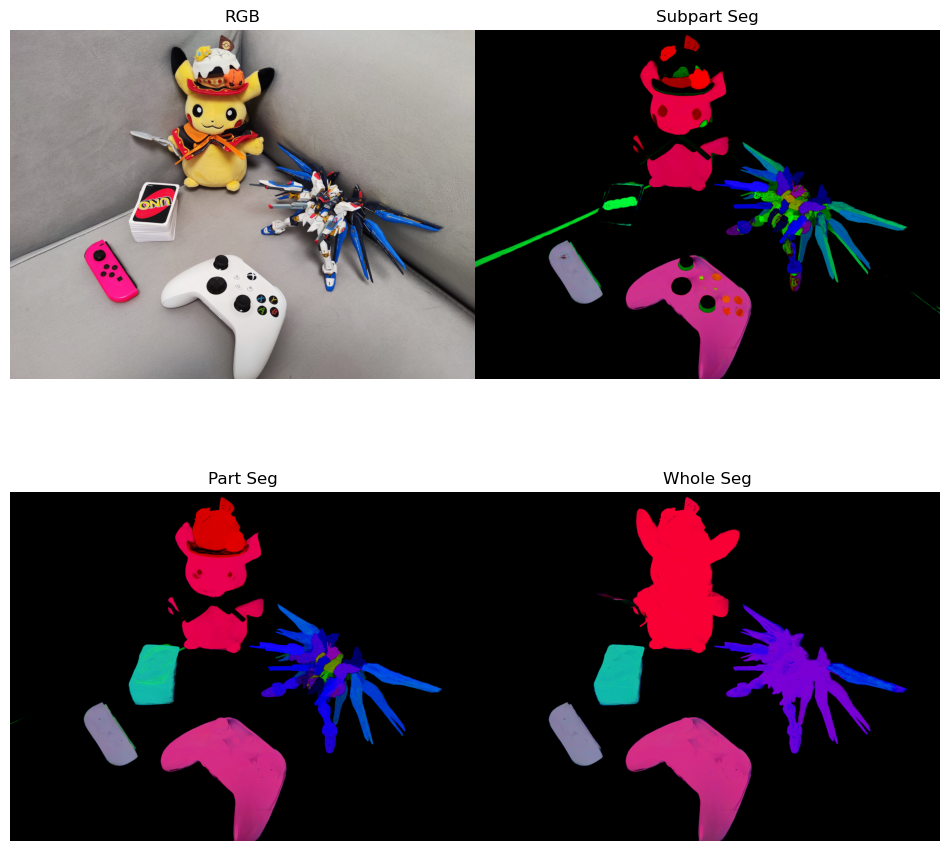

In [5]:
# TODO: pull image and features from gaussian splat
# for now lets load available data

# define path and names
sel_img_num = 9

rgb_img_path = os.path.join(ds_dir,'images',f'{sel_img_num:02d}.jpg')
sem_feature_paths = [os.path.join(output_dir, dataset_name+f"_{i}", "train/ours_None/renders_npy",
                                  f'{sel_img_num:05d}.npy')
                     for i in range(1,4)]
sem_render_paths = [os.path.join(output_dir, dataset_name+f"_{i}", "train/ours_None/renders",
                                  f'{sel_img_num:05d}.png')
                     for i in range(1,4)] # not used in pipeline, for viz only

# loading
sem_feat = np.stack([np.load(sem_feat_path) for sem_feat_path in sem_feature_paths]) # (levels, height, width, encoded_dim)
rgb_img = cv2.imread(rgb_img_path)[..., ::-1]
rgb_img = (rgb_img / 255.0).astype(np.float32)
sem_img = np.stack([cv2.imread(sem_render_path) for sem_render_path in sem_render_paths])

# visualize selected imgs
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs[0,0].imshow(rgb_img)
axs[0,0].title.set_text('RGB')
axs[0,1].imshow(sem_img[0])
axs[0,1].title.set_text('Subpart Seg')
axs[1,0].imshow(sem_img[1])
axs[1,0].title.set_text('Part Seg')
axs[1,1].imshow(sem_img[2])
axs[1,1].title.set_text('Whole Seg')
plt.subplots_adjust(wspace=0, hspace=0)
[ax.axis('off') for ax_row in axs for ax in ax_row];

In [6]:
# decoding of feature to original clip feature space

sem_feat = torch.from_numpy(sem_feat).float().to(device)
rgb_img = torch.from_numpy(rgb_img).to(device)

with torch.no_grad():
    lvl, h, w, _ = sem_feat.shape
    restored_feat = model.decode(sem_feat.flatten(0, 2))
    restored_feat = restored_feat.view(lvl, h, w, -1)           # (levels, height, width, clip_dim)

In [12]:
# cosine comparison
queries = ['pikachu','gundam'] #N queries

clip_model.set_positives(queries)

valid_map = clip_model.get_max_across(restored_feat) # (levels, num_queries, height, width)
n_head, n_prompt, h, w = valid_map.shape

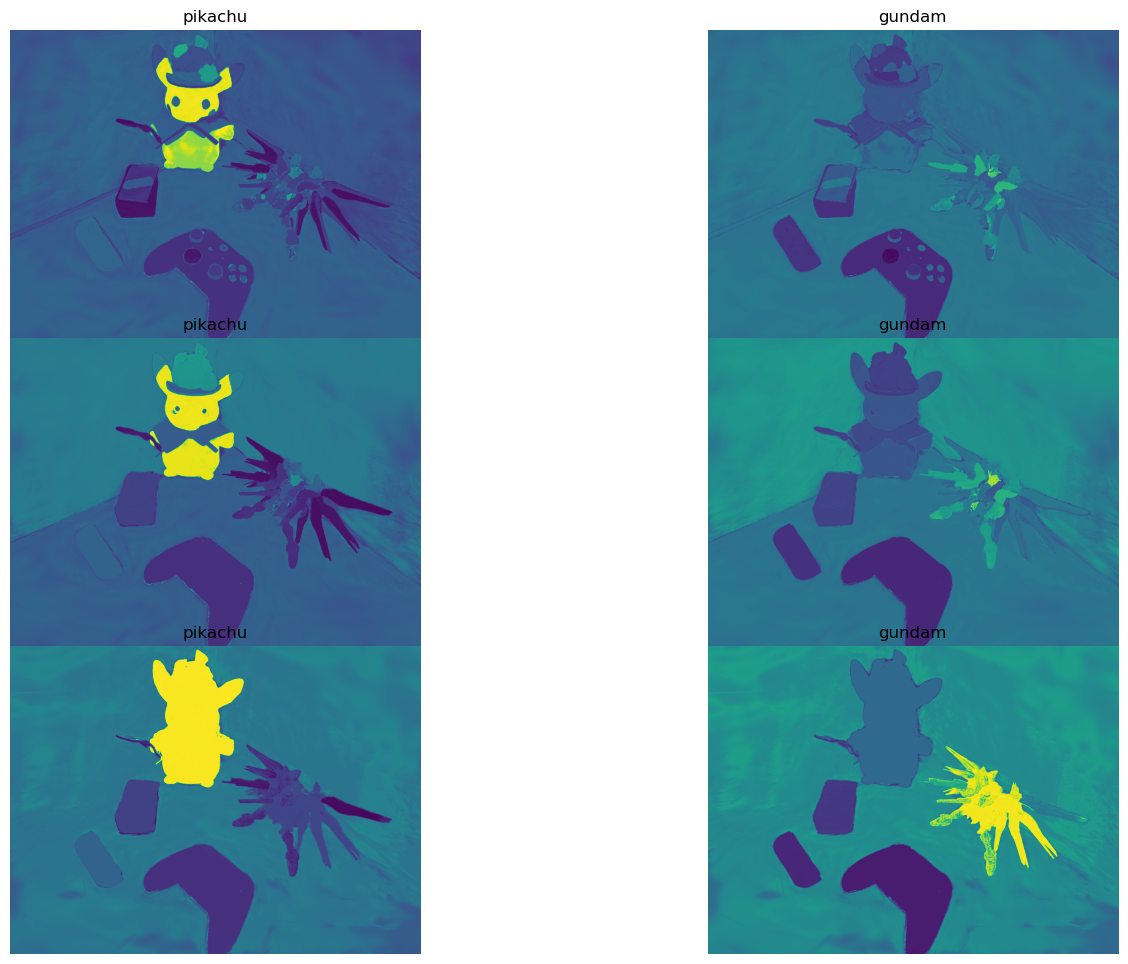

In [15]:
# visualize selected imgs
fig, axs = plt.subplots(n_head, n_prompt, figsize=(6*n_head,6*n_prompt))
for i in range(n_head):
    for j in range(n_prompt):
        axs[i,j].imshow(valid_map[i,j,...].cpu().numpy())
        axs[i,j].title.set_text(queries[j])
        plt.subplots_adjust(wspace=0, hspace=0)
[ax.axis('off') for ax_row in axs for ax in ax_row];